The notebook covers Following Topics:

- Missing Value Analysis
- Correlation Analysis
- Top Contributing Features (Through XGBoost)
- Correlation Analysis
- Multicollinearity Analysis
- Univariate Analysis
- Bivariate Analysis
- Missing value filling using KNN algorithm


In [395]:
import numpy as np # linear algebra
from numpy.distutils.system_info import numpy_info
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import *
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from ggplot import *

- parcelid (Id which represents parcel)
- logerror (logerror = log(zestimate) - log(salesprice))
- transactiondate (Date at which the property got sold out)

In [396]:
train_df_temp = pd.read_csv("../train_2016_v2.csv", parse_dates=["transactiondate"])
train_df_temp.shape

(90275, 3)

Target variable for this competition is 'logerror'. Below graph shows how logerror scattered scross all the data points.

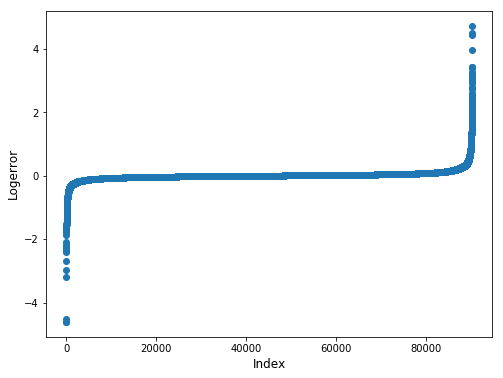

In [398]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df_temp.shape[0]), np.sort(train_df_temp.logerror.values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Logerror', fontsize=12)
plt.show()

Below code will remove the outliers for target variable logerror. The code will set the upper limit as 99 percentile and lower limit as 1 percentile to remove the outliers. It also create the scatter plot which shows the normal distrubution of the logerro variable. 

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


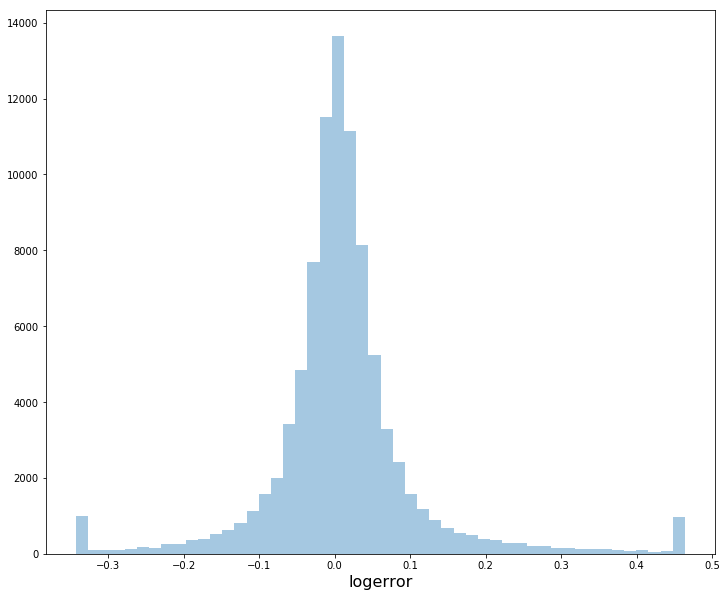

In [399]:
ulimit = np.percentile(train_df_temp.logerror.values, 99)
llimit = np.percentile(train_df_temp.logerror.values, 1)
train_df_temp.logerror.loc[train_df_temp['logerror'] > ulimit] = ulimit
train_df_temp.logerror.loc[train_df_temp['logerror'] < llimit] = llimit

plt.figure(figsize=(12, 10))
sns.distplot(train_df_temp.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=16)
plt.show()

Below graph shows the distrubution of the data points based on the transaction months. It shows the number of properties sold out for each month available in the dataset.

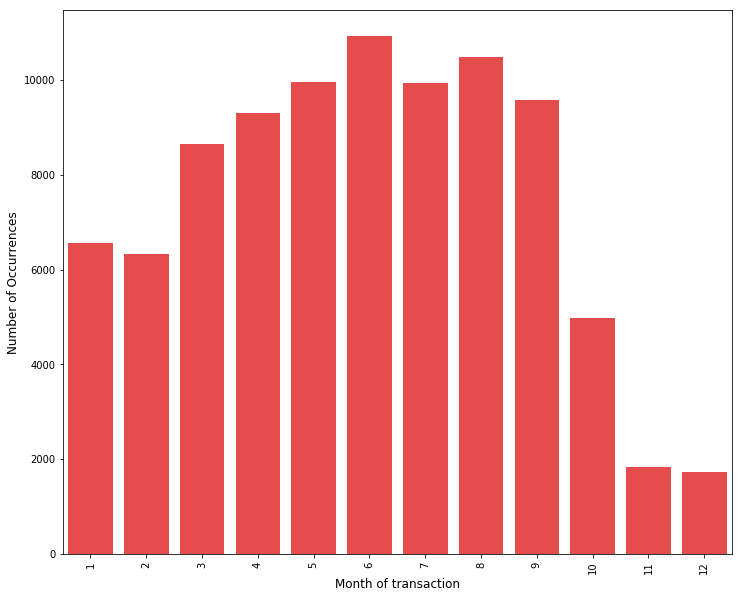

In [400]:
train_parcel_data = train_df_temp
train_parcel_data['transaction_month'] = train_parcel_data['transactiondate'].dt.month

cnt_srs = train_parcel_data['transaction_month'].value_counts()

plt.figure(figsize=(12, 10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='red')
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In the above graph, as we could see, we have shorter bars in the last three months since the train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

Most of the parcel ids are unique and appear only once in the dataset

In [401]:
(train_parcel_data['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

# Exploring the properties_2016 file:

"properties_2016_10k.csv" file contains data related to the property available from the zillow database along with the attributes associated with it.

In [402]:
prop_df = pd.read_csv("../properties_2016_10k.csv")
prop_df.shape

(10000, 59)

Lets count the number of missing values in each column first.

In [403]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')

There are so many NaN values in the dataset.

In [404]:
missing_df

,column_name,missing_count
54,taxamount,1
39,regionidzip,3
50,structuretaxvaluedollarcnt,30
11,calculatedfinishedsquarefeet,68
57,censustractandblock,71
47,yearbuilt,78
8,calculatedbathnbr,117
19,fullbathcnt,117
36,regionidcity,201
12,finishedsquarefeet12,460


Below code type cast all float64 columns to float32 to shrink the size of the dataset.
It also merge the dataset from "train_2016_v2.csv" file and "properties_2016_10k.csv" based on parcelid.

In [405]:
for clm, dtype in zip(prop_df.columns, prop_df.dtypes):
    if dtype == np.float64:
        prop_df[clm] = prop_df[clm].astype(np.float32)
train_df = train_df_temp.merge(prop_df, how='left', on='parcelid')

del train_df_temp, prop_df, train_parcel_data
train_df.drop(['parcelid','transactiondate'], axis=1, inplace=True)

We have calculated the mean for each columns and replaced all null value with mean value for respective column. The reason behind doingmean for the collumn is to get rid of null value with appropriate value for that column.

In [406]:
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)

In [409]:
train_df_new_y = train_df_new['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df_new = train_df_new.drop(['logerror']+cat_cols, axis=1)
feat_names = train_df_new.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df_new, train_df_new_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

KeyError: 'logerror'

Below graph to show the important feature from the dataset by removing all categorical features using XGBoost algorithm.

[03:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8


[03:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8


[03:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8


[03:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8


[03:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8


[03:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8


[03:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8


[03:39:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8


[03:39:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8


[03:39:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8


[03:39:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8


[03:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8


[03:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8


[03:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8


[03:39:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8


[03:39:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8


[03:39:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8


[03:39:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8


[03:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8


[03:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8


[03:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8


[03:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8


[03:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8


[03:39:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8


[03:39:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8


[03:39:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8


[03:39:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8


[03:39:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=8


[03:39:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8


[03:39:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8


[03:39:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8


[03:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8


[03:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8


[03:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8


[03:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8


[03:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8


[03:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8


[03:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8


[03:39:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8


[03:39:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8


[03:39:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8


[03:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8


[03:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8


[03:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8


[03:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8


[03:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=8


[03:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8


[03:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8


[03:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8


[03:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8


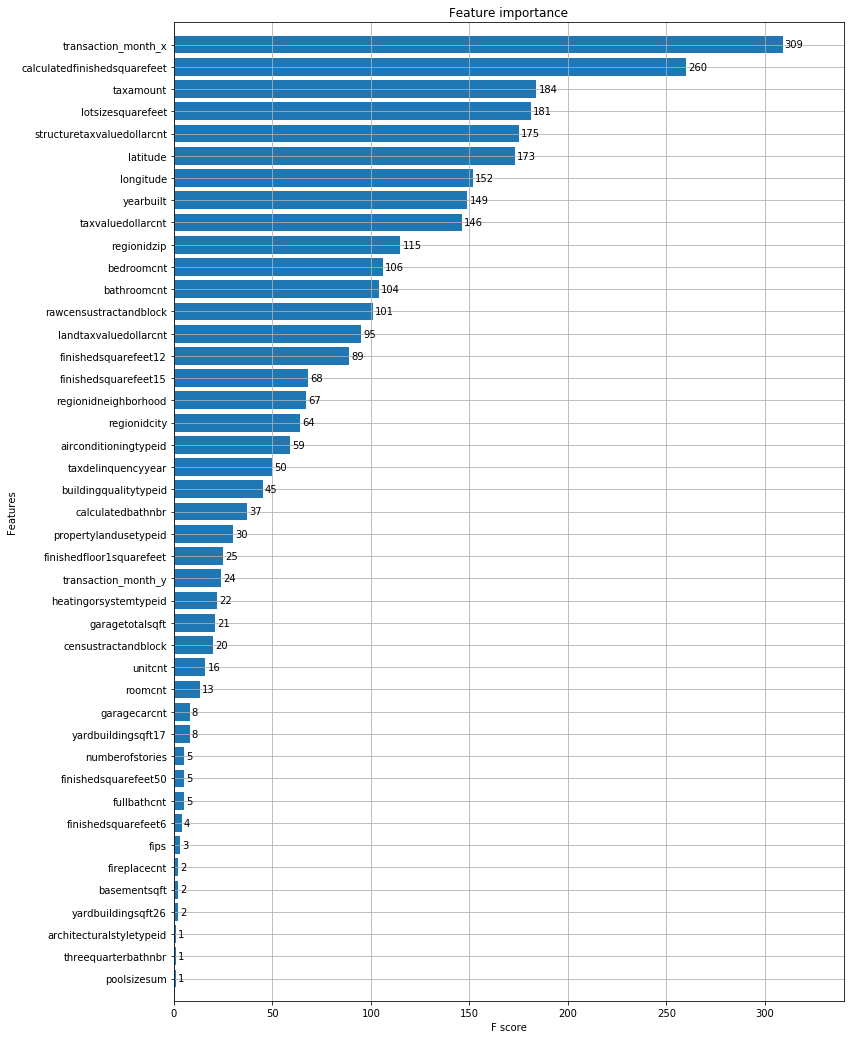

In [410]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed': 0
}
dtrain = xgb.DMatrix(train_df_new, train_df_new_y, feature_names=train_df_new.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12, 18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

From the above graph, we could choose few feature to remove form the dataset which don't have importance.

In [412]:
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'fullbathcnt','finishedsquarefeet15','finishedsquarefeet6','finishedsquarefeet50','calculatedbathnbr']


Lets begin with analysis of missing values to figure out a way to handle them

In [413]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column_Type"]
dtype_df.groupby("Column_Type").aggregate('count').reset_index()

,Column_Type,Count
0,int64,1
1,float32,41
2,float64,13
3,object,5


number of column with different datatype.

Below graph shows the number of Null values for each columns.

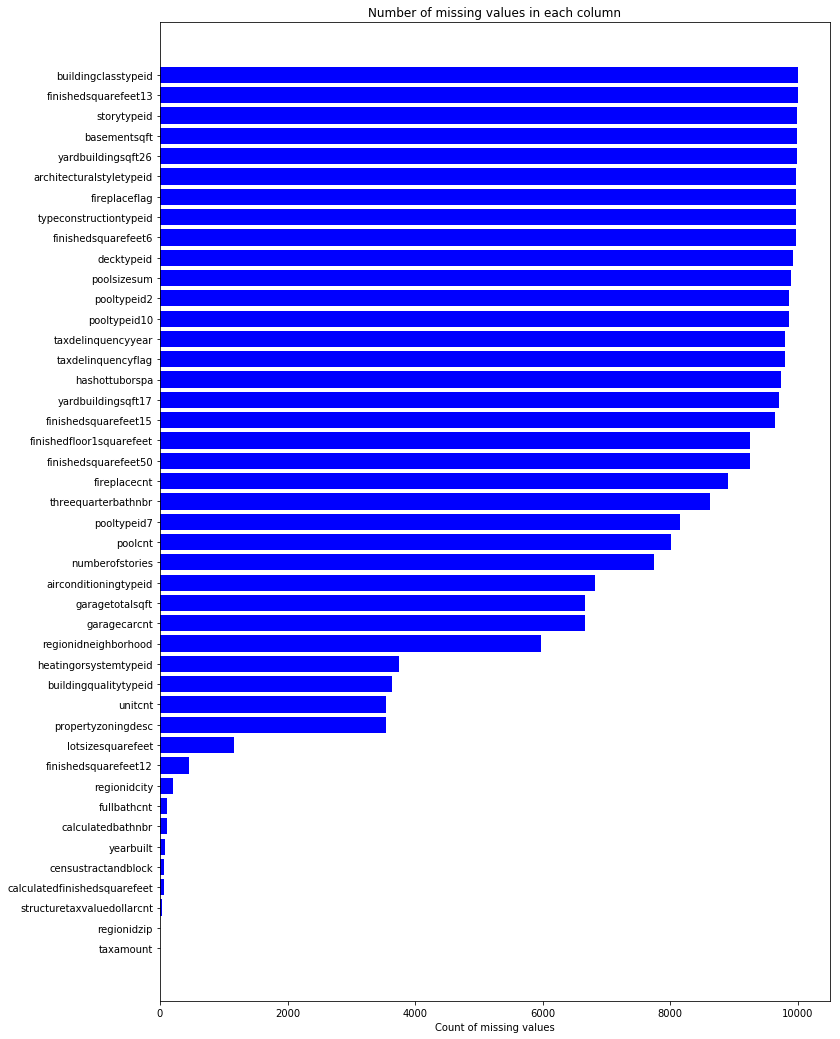

In [414]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [415]:
train_df.drop(columns=['transaction_month_x','transaction_month_y'],axis=1,inplace=True)

Below graph shows the geographical infomation of properties from the dataset.

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

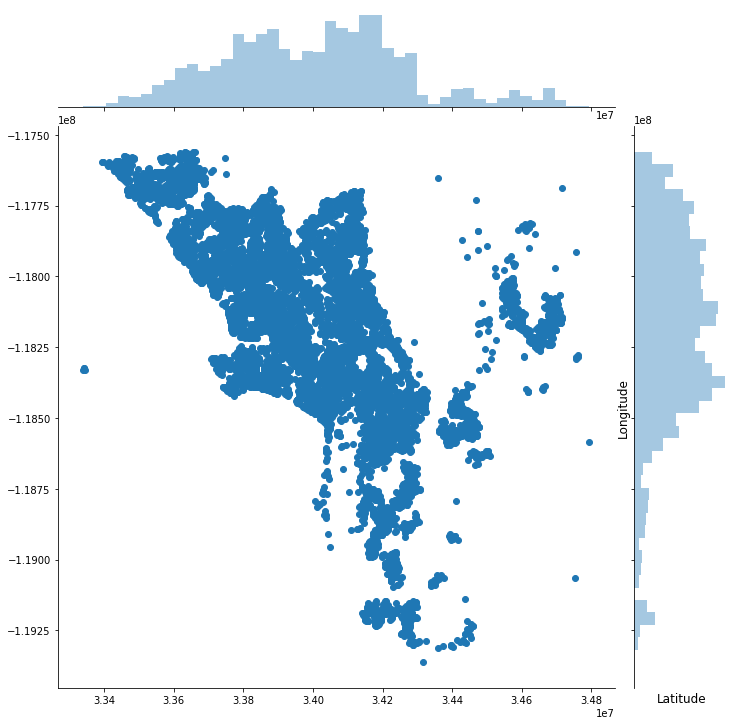

In [416]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.latitude.values, y=train_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

Basic null value replacement for the dataset.

In [417]:
values = {'hashottuborspa': "None", 'fireplacecnt': 0,'pooltypeid2': 0, 'pooltypeid7': 0, 'poolcnt':'0', 'taxdelinquencyflag': "None", 'garagecarcnt': 0, 'garagetotalsqft' : 0, 'airconditioningtypeid' : 1, 'heatingorsystemtypeid' : 2, 'threequarterbathnbr':1}
train_df.fillna(value=values, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90309 entries, 0 to 90308
Data columns (total 58 columns):
logerror                        90309 non-null float64
airconditioningtypeid           90309 non-null float32
architecturalstyletypeid        24 non-null float32
basementsqft                    5 non-null float32
bathroomcnt                     10034 non-null float32
bedroomcnt                      10034 non-null float64
buildingclasstypeid             2 non-null float32
buildingqualitytypeid           6378 non-null float32
calculatedbathnbr               9915 non-null float32
decktypeid                      75 non-null float32
finishedfloor1squarefeet        760 non-null float32
calculatedfinishedsquarefeet    9964 non-null float32
finishedsquarefeet12            9568 non-null float32
finishedsquarefeet13            3 non-null float32
finishedsquarefeet15            362 non-null float32
finishedsquarefeet50            760 non-null float32
finishedsquarefeet6             31 non-

Column "hashottuborspa" and "pooltypeid10" have same information in the dataset as per the disciprion give in the kaggle which means it contains the redundant data.

In [418]:
print(train_df.hashottuborspa.value_counts())
print(train_df.pooltypeid10.value_counts())

dropcols.append('pooltypeid10')

None    90049
True      260
Name: hashottuborspa, dtype: int64
1.0    130
Name: pooltypeid10, dtype: int64


I have taken median of the "poolsizesum" column for the rows where "poolcnt" is not zero.
We will replace this median value to the null value in the column"poolsizesum" where "poolcnt" column is not zero. Rest of the rows for "poolsizesum" will be assigned as zero.

In [419]:
 train_sample = train_df

In [420]:
train_df.poolcnt = train_df.poolcnt.astype('int32')
poolsizemedian = train_df.loc[train_df['poolcnt'] > 0, 'poolsizesum'].median()
train_df.loc[(train_df['poolcnt'] > 0) & (train_df['poolsizesum'].isnull()), 'poolsizesum'] = poolsizemedian
train_df.loc[train_df['poolcnt'] > 0, 'poolsizesum'] = 0

Fireplace flag will be "yes" for the rows whose "fireplacecnt" column is not zero. Rest of the rows for "fireplaceflag" will be "No".

In [421]:
train_df['fireplaceflag'] = "No"
train_df.loc[train_df['fireplacecnt'] > 0,'fireplaceflag'] = "Yes"

Removing the columns whose having null values more than 97% of the total values.

In [422]:
missing_values_prop = (train_df.isnull().sum()/len(train_df)).reset_index()
missing_values_prop.columns = ['Column_Name', 'proportion']
missing_values_prop.sort_values(by='proportion', ascending=False, inplace=True)
missing_prop_cols = missing_values_prop[missing_values_prop['proportion'] > 0.97].Column_Name.tolist()

In [436]:
# we have to drop any rows which contain null value in latitude or longitude column. 
train_df.dropna(axis=0, how='any', subset=['latitude', 'longitude'], inplace=True)

def fillna_value_using_knn(df, base, target, fraction=1, thresold = 10, n_neighbors = 5):
    assert isinstance(base, list) or isinstance(base, np.ndarray) and isinstance(target, string)
    whole = [target] + base
    
    ms = df[target].isnull()
    notms = ~ms
    numms = ms.sum()
    print("Number of missing value",numms)
    #enc = OneHotEncoder()
    x_target = df.loc[notms, whole].sample(frac=fraction)
    #enc.fit(x_target[target].unique().reshape((-1, 1)))
    
    #y = enc.transform(x_target[target].values.reshape((-1, 1))).toarray()
    y = x_target[target]
    x = x_target[base]
    #print(y)
    #print('knn neighbors')
    clf = KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(x, y)
    #print(np.all(np.isfinite(df.loc[ms, base])))
    y_predict = clf.predict(df.loc[ms, base])
    #print("Accuracy for the model", clf.score(df.loc[ms, base], y))
    #print("Predicted",y_predict)
    
    numpredict = len(y_predict)
    
    #if numpredict/numms*100 < thresold:
    print('write result to df')
    df.loc[ms, target] = pd.DataFrame(y_predict)
    print('num of unpredicted data:', numpredict)
    #return enc
    #else:
        #print('out of thresold')
        
        
def zoningcode2int(df, target):
    storenull = df[target].isnull()
    enc = LabelEncoder()
    df[target] = df[target].astype(str)

    print('fit and transform')
    df[target] = enc.fit_transform(df[target].values)
    print('num of categories: ', enc.classes_.shape)
    df.loc[storenull, target] = np.nan
    print('recover the nan value')
    #return enc

In [437]:
fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='buildingqualitytypeid', fraction=0.15, n_neighbors=1)


#if(np.all(train_df.propertycountylandusecode.isnull())):
    #zoningcode2int(df=train_df, target='propertycountylandusecode')
    #fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='propertycountylandusecode', fraction=0.15, n_neighbors=1)

#if(np.all(train_df.propertyzoningdesc.isnull())):
    #zoningcode2int(df=train_df, target='propertyzoningdesc')
    #fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='propertyzoningdesc', fraction=0.15, n_neighbors=1)

#fillna_value_using_knn(df=train_df,base=['latitude', 'longitude'], target='regionidcity', fraction=0.15, n_neighbors=1)

#fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='regionidneighborhood', fraction=0.15, n_neighbors=1)

#fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='regionidzip', fraction=0.15, n_neighbors=1)

#fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='unitcnt', fraction=0.15, n_neighbors=1)

#fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='yearbuilt', fraction=0.15, n_neighbors=1)

#fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='lotsizesquarefeet', fraction=0.15, n_neighbors=1)

Number of missing value 3656
30792     7.0
10778     4.0
43508     4.0
67196     4.0
48591     7.0
77945     7.0
10390     7.0
88300     1.0
24684     1.0
40378     4.0
11411     4.0
39783     4.0
14268     7.0
58440    10.0
53490     7.0
59842     7.0
71652     7.0
71079     7.0
74177     7.0
63517     7.0
72522     4.0
52835     1.0
34450     4.0
41742     7.0
52257     7.0
68723     4.0
63008     4.0
14218    10.0
15307     4.0
69954     1.0
         ... 
35778     7.0
61577    10.0
65579     4.0
44480     1.0
4501      7.0
38799     4.0
65371     1.0
59728     7.0
20326     7.0
7896      4.0
53200     4.0
48844     7.0
36607    10.0
48739     4.0
60436     4.0
86785     7.0
19436     4.0
70909     7.0
6062      4.0
88297     4.0
83744     4.0
22389     4.0
51490     7.0
85807     7.0
22802     7.0
57455     7.0
45779     4.0
35001     4.0
75202     7.0
17421     4.0
Name: buildingqualitytypeid, Length: 957, dtype: float32
Predicted [4. 4. 4. ... 4. 4. 4.]
write result to df
num of 

In [241]:
train_df.loc[(train_df['finishedfloor1squarefeet'].isnull()) & (train_df['numberofstories'] == 1), 'finishedfloor1squarefeet'] = train_df.loc[(train_df['finishedfloor1squarefeet'].isnull()) & (train_df['numberofstories'] == 1), 'calculatedfinishedsquarefeet']

droprows = train_df.loc[train_df['calculatedfinishedsquarefeet'] < train_df['finishedfloor1squarefeet']].index
train_df = train_df.drop(droprows)

train_df.loc[train_df.taxvaluedollarcnt.isnull(), 'taxvaluedollarcnt'] = train_df.loc[train_df.taxvaluedollarcnt.isnull(), 'taxamount']
train_df.loc[train_df.landtaxvaluedollarcnt.isnull(), 'landtaxvaluedollarcnt'] = train_df.loc[train_df.landtaxvaluedollarcnt.isnull(), 'taxamount']

In [242]:
dropcols = dropcols + missing_prop_cols
print(dropcols)
train_df.drop(dropcols, axis=1, inplace=True)

['finishedsquarefeet12', 'finishedsquarefeet13', 'fullbathcnt', 'finishedsquarefeet15', 'finishedsquarefeet6', 'finishedsquarefeet50', 'calculatedbathnbr', 'pooltypeid10', 'buildingclasstypeid', 'finishedsquarefeet13', 'storytypeid', 'basementsqft', 'yardbuildingsqft26', 'architecturalstyletypeid', 'typeconstructiontypeid', 'finishedsquarefeet6', 'decktypeid', 'pooltypeid10', 'taxdelinquencyyear', 'yardbuildingsqft17', 'finishedsquarefeet15', 'finishedfloor1squarefeet', 'finishedsquarefeet50', 'poolsizesum', 'numberofstories']


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


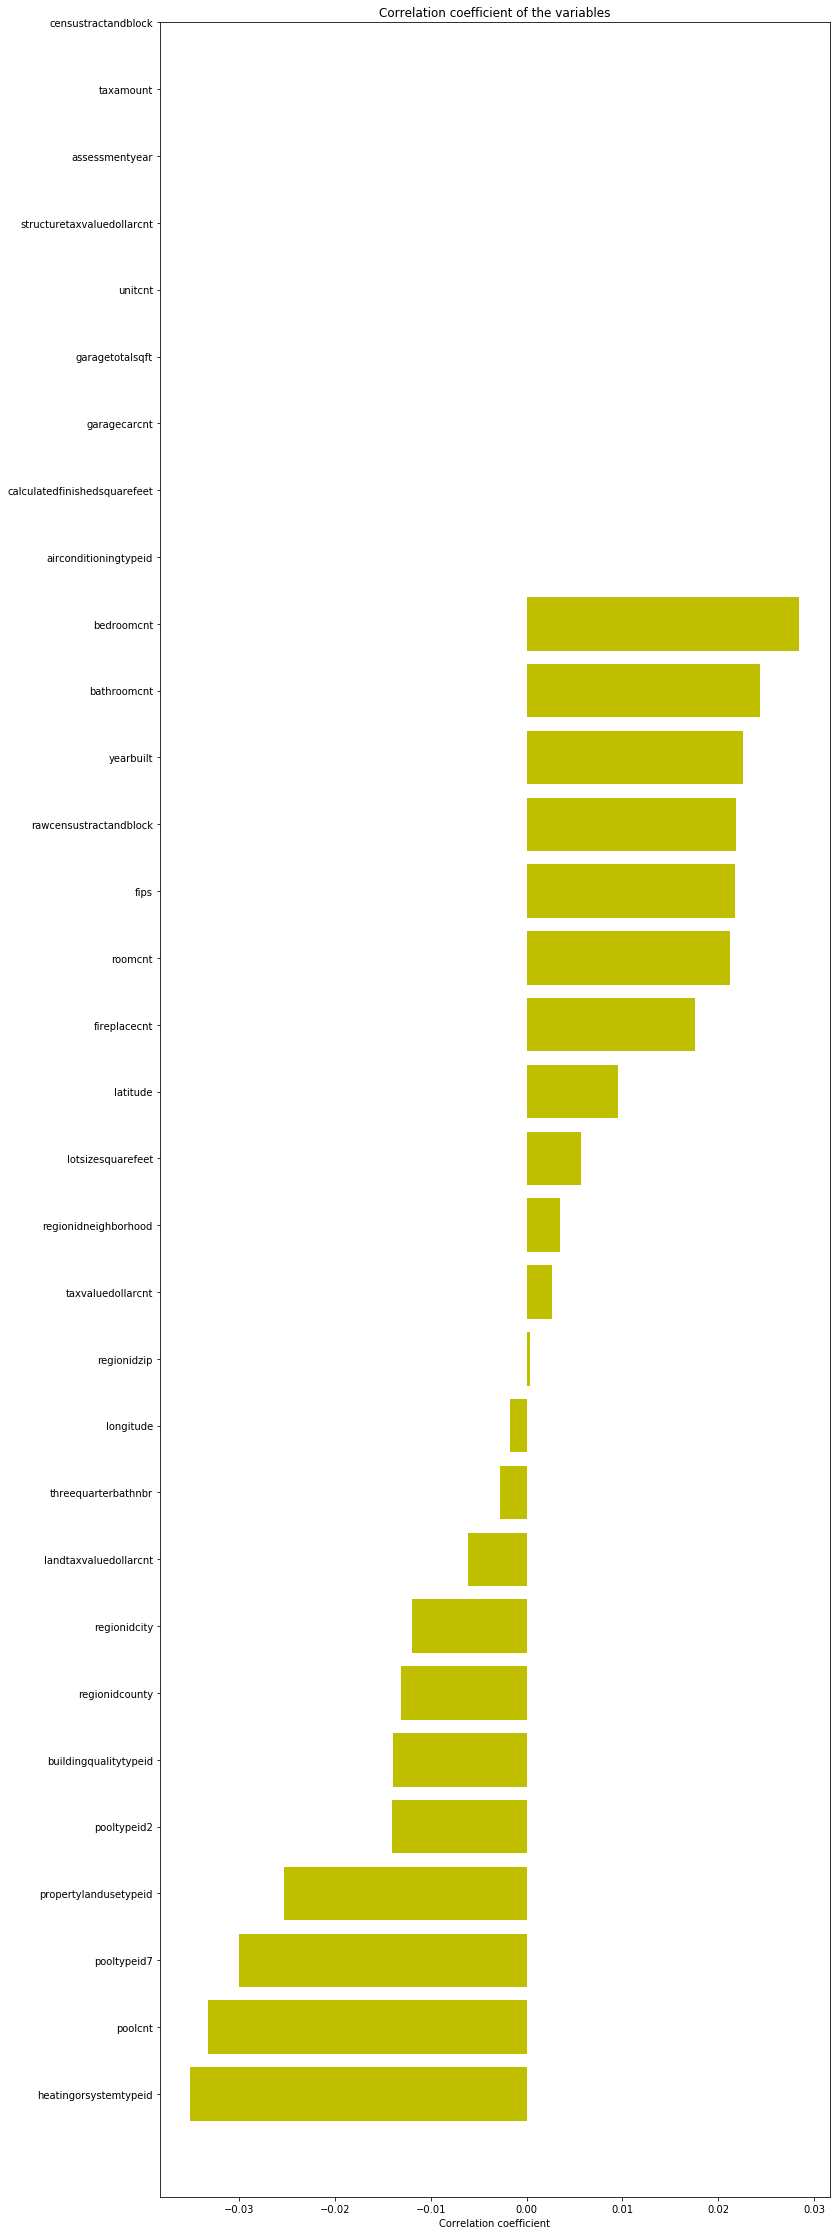

In [243]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float32']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
#train_df.head()
#corr_df.head()
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

Lets figure out variables with high correlation and then do some analysis on them.

In [244]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,col_labels,corr_values
9,heatingorsystemtypeid,-0.035080
13,poolcnt,-0.033204
15,pooltypeid7,-0.029993
16,propertylandusetypeid,-0.025271
14,pooltypeid2,-0.014006
3,buildingqualitytypeid,-0.013938
19,regionidcounty,-0.013105
18,regionidcity,-0.011940
22,roomcnt,0.021261
5,fips,0.021686


In [245]:
def variation(col, col_name, title):
    ulimit = np.percentile(col.values, 99.5)
    llimit = np.percentile(col.values, 0.5)
    col.ix[col>ulimit] = ulimit
    col.ix[col<llimit] = llimit

    plt.figure(figsize=(12,12))
    sns.jointplot(x=col.values, y=train_df.logerror.values, size=10, color='blue')
    plt.ylabel('Log Error', fontsize=12)
    plt.xlabel(col_name, fontsize=12)
    plt.title(title, fontsize=15)
    plt.show()

Finished Square Feet 12

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:5: 

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

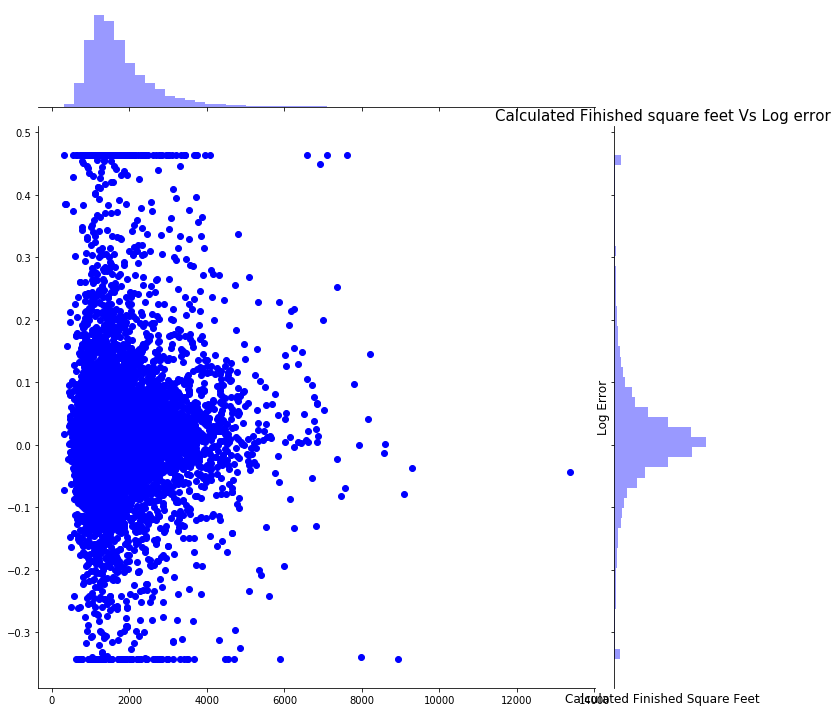

In [246]:
variation(train_df.calculatedfinishedsquarefeet, 'Calculated Finished Square Feet', "Calculated Finished square feet Vs Log error")

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:5: 

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

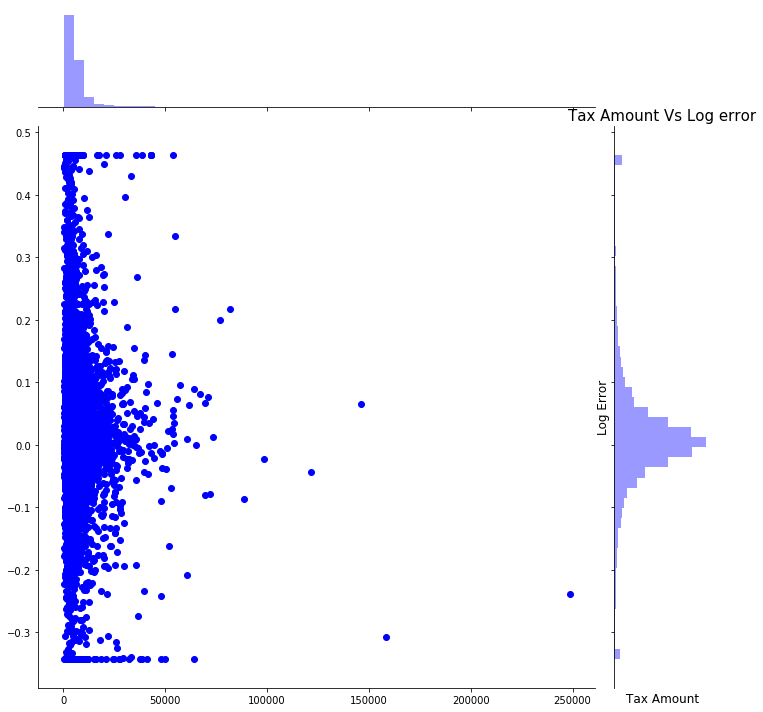

In [247]:
variation(train_df.taxamount, 'Tax Amount', "Tax Amount Vs Log error")

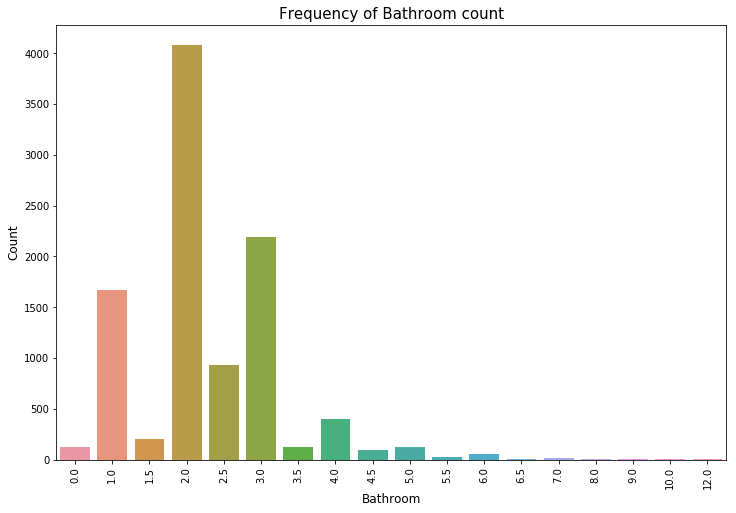

In [248]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

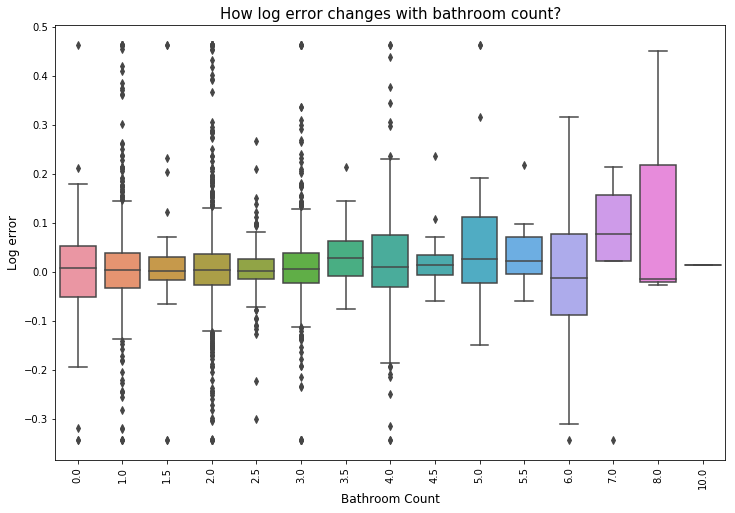

In [204]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

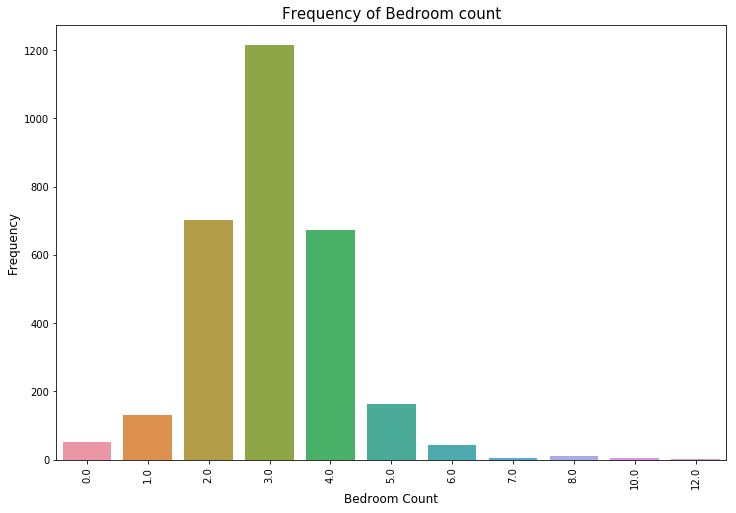

In [205]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an 

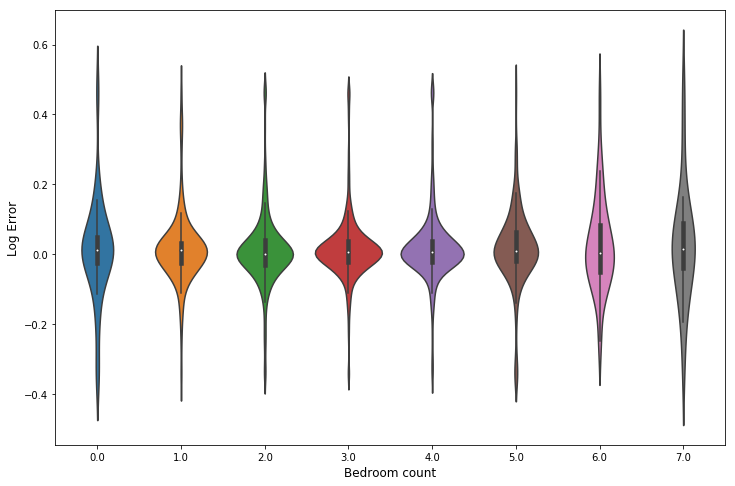

In [146]:
train_df['bedroomcnt'].ix[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

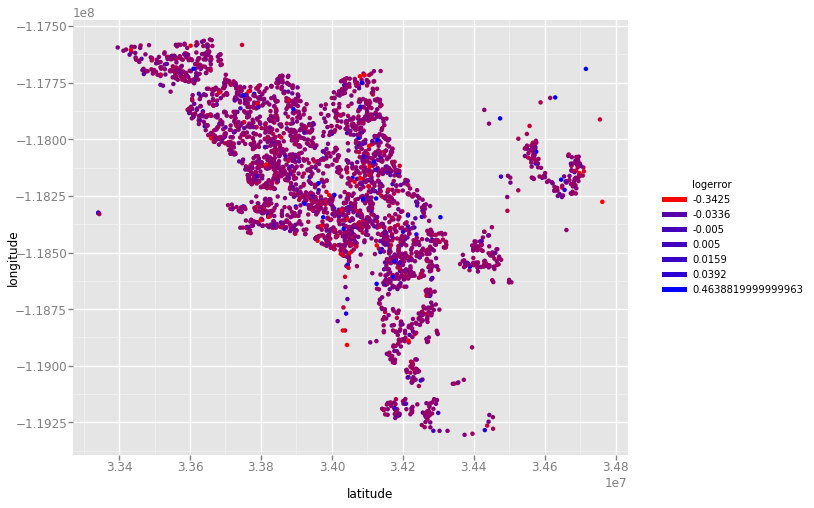

<ggplot: (-9223371908896228955)>

In [206]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

In [209]:
sample_df= train_df.isnull().sum(axis=0).reset_index()
sample_df.columns = ['column_name','cnt']
sample_df = sample_df.loc[sample_df['cnt']>=0]
print(sample_df.column_name.values)

['airconditioningtypeid' 'bathroomcnt' 'bedroomcnt'
 'buildingqualitytypeid' 'finishedfloor1squarefeet'
 'calculatedfinishedsquarefeet' 'fips' 'fireplacecnt' 'garagecarcnt'
 'garagetotalsqft' 'hashottuborspa' 'heatingorsystemtypeid' 'latitude'
 'longitude' 'lotsizesquarefeet' 'poolcnt' 'poolsizesum' 'pooltypeid2'
 'pooltypeid7' 'propertycountylandusecode' 'propertylandusetypeid'
 'propertyzoningdesc' 'rawcensustractandblock' 'regionidcity'
 'regionidcounty' 'regionidneighborhood' 'regionidzip' 'roomcnt'
 'threequarterbathnbr' 'unitcnt' 'yardbuildingsqft17' 'yearbuilt'
 'numberofstories' 'fireplaceflag' 'structuretaxvaluedollarcnt'
 'taxvaluedollarcnt' 'assessmentyear' 'landtaxvaluedollarcnt' 'taxamount'
 'taxdelinquencyflag' 'censustractandblock' 'logerror' 'transaction_month']
